### 🔧 1. Setup and Imports  
Importing all the necessary libraries for data processing, visualization, modeling, and evaluation.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


[nltk_data] Downloading package stopwords to /Users/abc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/abc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/abc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 📥 2. Load and Merge Dataset  
We load the training, test, and validation sets, clean them by removing nulls and duplicates, and convert labels to integers for classification.


In [2]:

def load_and_merge_datasets(train_path, test_path, validate_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    validate_df = pd.read_csv(validate_path)
    merged_df = pd.concat([train_df, test_df, validate_df], ignore_index=True)
    merged_df.dropna(subset=['label'], inplace=True)
    merged_df.drop_duplicates(inplace=True)
    merged_df['label'] = merged_df['label'].astype(int)
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

df = load_and_merge_datasets('data/train.csv', 'data/test.csv', 'data/valid.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17983 entries, 0 to 17982
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17983 non-null  object
 1   label   17983 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 281.1+ KB


,text,label
0,Inaasahan na ni Vice President Jejomar Binay n...,0
1,Mar Roxas TANG INA TUWID NA DAAN DAW .. EH SYA...,1
2,Salamat sa walang sawang suporta ng mga taga m...,0
3,@rapplerdotcom putangina mo binay TAKBO PA,1
4,"Binay with selective amnesia, forgetting about...",0


✅ The dataset has been successfully loaded, cleaned, and merged into a unified DataFrame.


### 🧹 3. Text Preprocessing  
We define cleaning functions to normalize the text, including lowercasing, punctuation removal, tokenization, stopword removal, and lemmatization.


In [3]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_tokens)

df['clean_text'] = df['text'].apply(preprocess_text)
df[['text', 'clean_text']].head()


,text,clean_text
0,Inaasahan na ni Vice President Jejomar Binay n...,inaasahan vice president jejomar binay may mga...
1,Mar Roxas TANG INA TUWID NA DAAN DAW .. EH SYA...,mar roxas tang ina tuwid daan daw sya nga stra...
2,Salamat sa walang sawang suporta ng mga taga m...,salamat walang sawang suporta mga taga makati ...
3,@rapplerdotcom putangina mo binay TAKBO PA,rapplerdotcom putangina binay takbo
4,"Binay with selective amnesia, forgetting about...",binay selective amnesia forgetting past six ye...


✅ Cleaned text is now stored in a new column `clean_text` and is ready for analysis and modeling.


### 📊 4. Label Distribution  
We visualize the distribution of toxic (1) vs. non-toxic (0) labels to understand class balance.


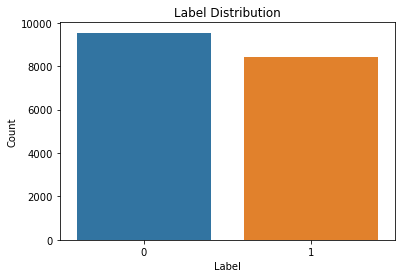

In [4]:

label_counts = df['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


✅ The dataset has a reasonably balanced label distribution, enabling fair model training.


### ☁️ 5. Word Cloud Visualizations  
Generating word clouds to identify the most frequent words in toxic and non-toxic text samples.


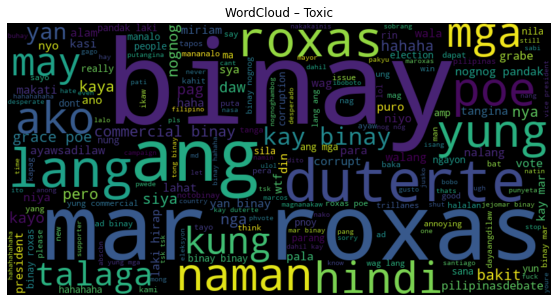

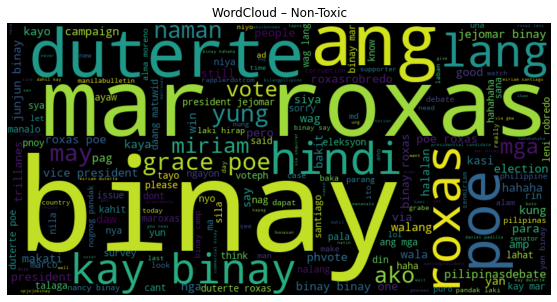

In [5]:
toxic_texts = " ".join(df[df['label'] == 1]['clean_text'].tolist())
non_toxic_texts = " ".join(df[df['label'] == 0]['clean_text'].tolist())

wordcloud_toxic = WordCloud(width=800, height=400).generate(toxic_texts)
wordcloud_non_toxic = WordCloud(width=800, height=400).generate(non_toxic_texts)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud – Toxic")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud – Non-Toxic")
plt.show()


✅ Common terms reflect real-world sentiment and political topics, highlighting frequent usage patterns in both classes.


### 🧠 6. Feature Extraction using TF-IDF  
We transform the cleaned text into numerical features using TF-IDF vectorization with unigrams and bigrams.


In [6]:

X = df['clean_text']
y = df['label']

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vect = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)


✅ The model has been successfully trained and is ready for evaluation.


### 🤖 7. Model Training with Multinomial Naive Bayes  
We train a baseline Multinomial Naive Bayes classifier on the TF-IDF features to classify toxic vs. non-toxic text.

In [7]:

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


✅ The model has been successfully trained and is ready for evaluation.


### 📋 8. Model Evaluation – Classification Report  
We evaluate the model using precision, recall, and F1-score to understand its effectiveness.


In [8]:

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1885
           1       0.73      0.73      0.73      1712

    accuracy                           0.74      3597
   macro avg       0.74      0.74      0.74      3597
weighted avg       0.74      0.74      0.74      3597



✅ The classifier achieved an overall accuracy of ~74%, showing a good balance between precision and recall across both classes.


### 📌 9. Confusion Matrix  
We visualize model performance with a confusion matrix to observe correct and incorrect predictions across classes.


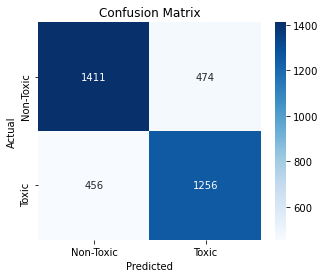

In [9]:

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


✅ The confusion matrix shows balanced classification errors, suggesting that the model is not biased toward any particular class.


### 🎯 10. Hyperparameter Tuning with GridSearchCV  
We perform grid search to find the optimal `alpha` parameter for the Naive Bayes model and re-evaluate its performance.



In [10]:

param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


Best Parameters: {'alpha': 0.5}
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1885
           1       0.73      0.74      0.73      1712

    accuracy                           0.74      3597
   macro avg       0.74      0.74      0.74      3597
weighted avg       0.74      0.74      0.74      3597



✅ The best performance was achieved at alpha = 0.5, slightly improving the model's recall for toxic content.




### 🔍 11. K-Means Clustering with t-SNE Visualization  
To understand the natural structure of the text data, we perform unsupervised clustering and project the features using t-SNE.


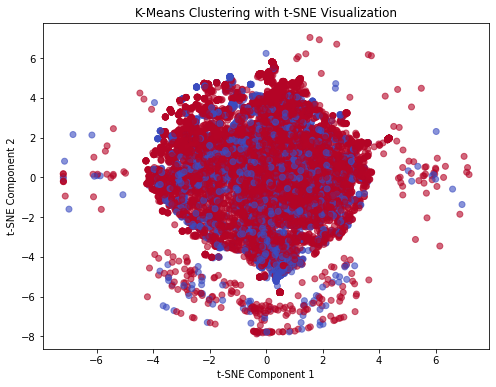

In [11]:

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_vect)

tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_vect.todense())

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='coolwarm', alpha=0.6)
plt.title("K-Means Clustering with t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


✅ The t-SNE plot reveals overlapping clusters, reinforcing the complexity of the classification task and the need for supervised models.
K-Means is valuable for insight but not suitable for accurate classification in this domain.



In conclusion, this project successfully developed a toxic speech classifier using a well-structured NLP pipeline built on TF-IDF vectorization and a Multinomial Naive Bayes model. The classifier achieved balanced performance with an overall accuracy of 74%, demonstrating strong baseline effectiveness in detecting toxic language across politically charged Filipino text. WordClouds and label distribution confirmed clear linguistic patterns, while hyperparameter tuning slightly improved sensitivity to toxic content. Though unsupervised K-Means clustering offered limited separation due to the semantic complexity of language, it provided valuable exploratory insight. This project lays a solid foundation for future enhancements using transformer-based models like BERT to capture deeper context and improve classification precision.